**This notebook will be dedicated to the training and optimization activities of an XGBoost regression model**

In [1]:
from src import data_utils, preprocessing
import matplotlib.pyplot as plt
import numpy as np

Only run the cell below by removing the # symbol if you haven't downloaded the zones data

In [2]:
# run this cell to download the required data files containing the trip and zones information

# data_utils.download_zones_data('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip')

In [ ]:
# this list contains the file names from where we wish to take all the data from
files = ['yellow_tripdata_2022-01.parquet',
         'yellow_tripdata_2022-02.parquet',
         'yellow_tripdata_2022-03.parquet',
         'yellow_tripdata_2022-04.parquet',
         'yellow_tripdata_2022-05.parquet',
         'yellow_tripdata_2022-06.parquet',
         'yellow_tripdata_2022-07.parquet',
         'yellow_tripdata_2022-08.parquet',
         'yellow_tripdata_2022-09.parquet',
         'yellow_tripdata_2022-10.parquet',
         'yellow_tripdata_2022-11.parquet',
         'yellow_tripdata_2022-12.parquet']

In [4]:
# first we get our cleaned data set
df_og = data_utils.sampled_yearly_data(files,250000)
# now we get our X, and y
X, y_travel_time, y_fare_amount = data_utils.get_feature_target(df_og)

In [5]:
y_fare_amount.max()

60.0

In [6]:
column_names_order = ['passenger_count','trip_distance','day','month','is_weekend','morning','afternoon','night']

In [7]:
# and we then get our training and testing sets
# we are going to get two sets of y labels, one for travel_time and another for fare_amount
X_train, X_test, y_train_travel_time, y_test_travel_time, y_train_fare_amount, y_test_fare_amount = data_utils.get_train_test_sets(X, y_travel_time, y_fare_amount)

In [8]:
# we can further split the training set into training and validation
X_train, X_val, y_train_travel_time, y_val_travel_time, y_train_fare_amount, y_val_fare_amount = data_utils.get_train_test_sets(X_train, y_train_travel_time, y_train_fare_amount)

In [9]:
# now using the training, validation, and testing sets we can preprocess our data
X_train, X_val, X_test = preprocessing.preprocess_data(X_train, X_val, X_test)

Input train data shape:  (1920000, 6)
Input val data shape:  (480000, 6)
Input test data shape:  (600000, 6) 

Output train data shape:  (1920000, 8)
Output val data shape:  (480000, 8)
Output test data shape:  (600000, 8)


**Initial results with no finetuning**

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [11]:
# initial run with no finetuning for fare amount
# fa = fare amount
xg_fa = XGBRegressor(seed=42)
xg_fa.fit(X_train,y_train_fare_amount)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
preds_fa = xg_fa.predict(X_val)

In [13]:
# measure our results
r2_fare = r2_score(y_val_fare_amount, preds_fa)
mae = mean_absolute_error(y_val_fare_amount, preds_fa)
rmse = root_mean_squared_error(y_val_fare_amount, preds_fa)
# agregar r2
print(f'R2 score: {r2_fare}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

R2 score: 0.952355210499554
Mean Absolute Error: 1.4080820404082532
Root Mean Squared Error: 2.3403873797712005


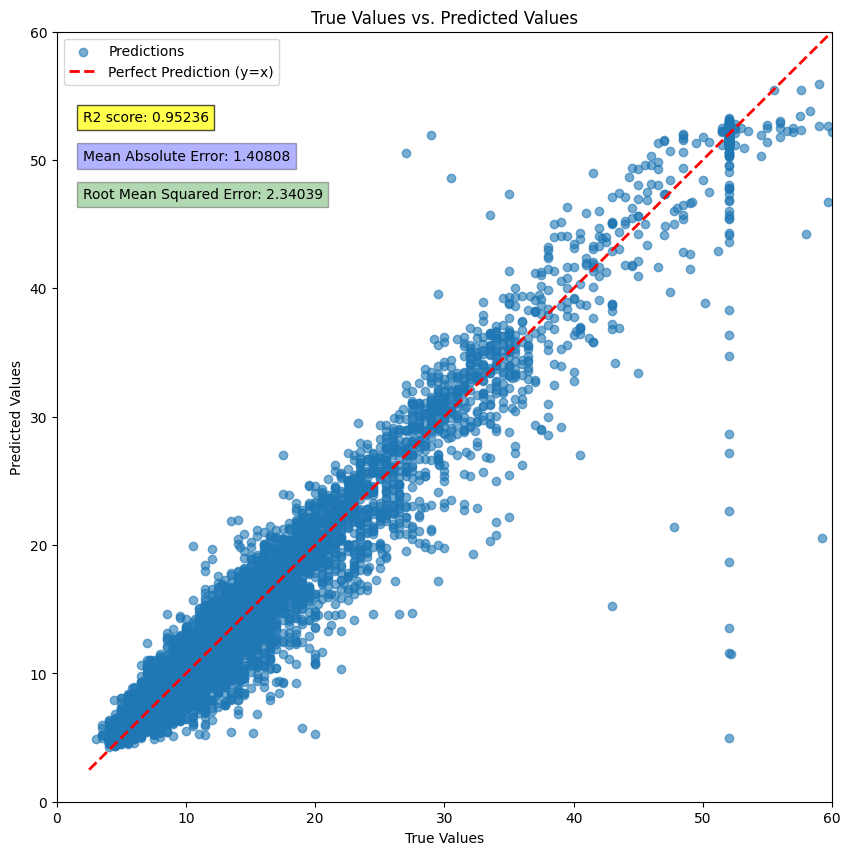

In [16]:
# plot the differences
plt.figure(figsize=(10,10))
plt.scatter(y_val_fare_amount[:10000], preds_fa[:10000], alpha=0.6, label='Predictions')
# axis limits
plt.xlim([0,60])
plt.ylim([0,60])
#plotting perfect line
min_val = min(np.min(y_val_fare_amount), np.min(preds_fa))
max_val = max(np.max(y_val_fare_amount), np.max(preds_fa))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
# other settings
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True Values vs. Predicted Values")
#plt.grid(True)
plt.legend()
plt.text(2,53,f'R2 score: {r2_fare:.5f}',bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(2,50,f'Mean Absolute Error: {mae:.5f}',bbox=dict(facecolor='blue', alpha=0.3))
plt.text(2,47,f'Root Mean Squared Error: {rmse:.5f}',bbox=dict(facecolor='green', alpha=0.3))
plt.show()

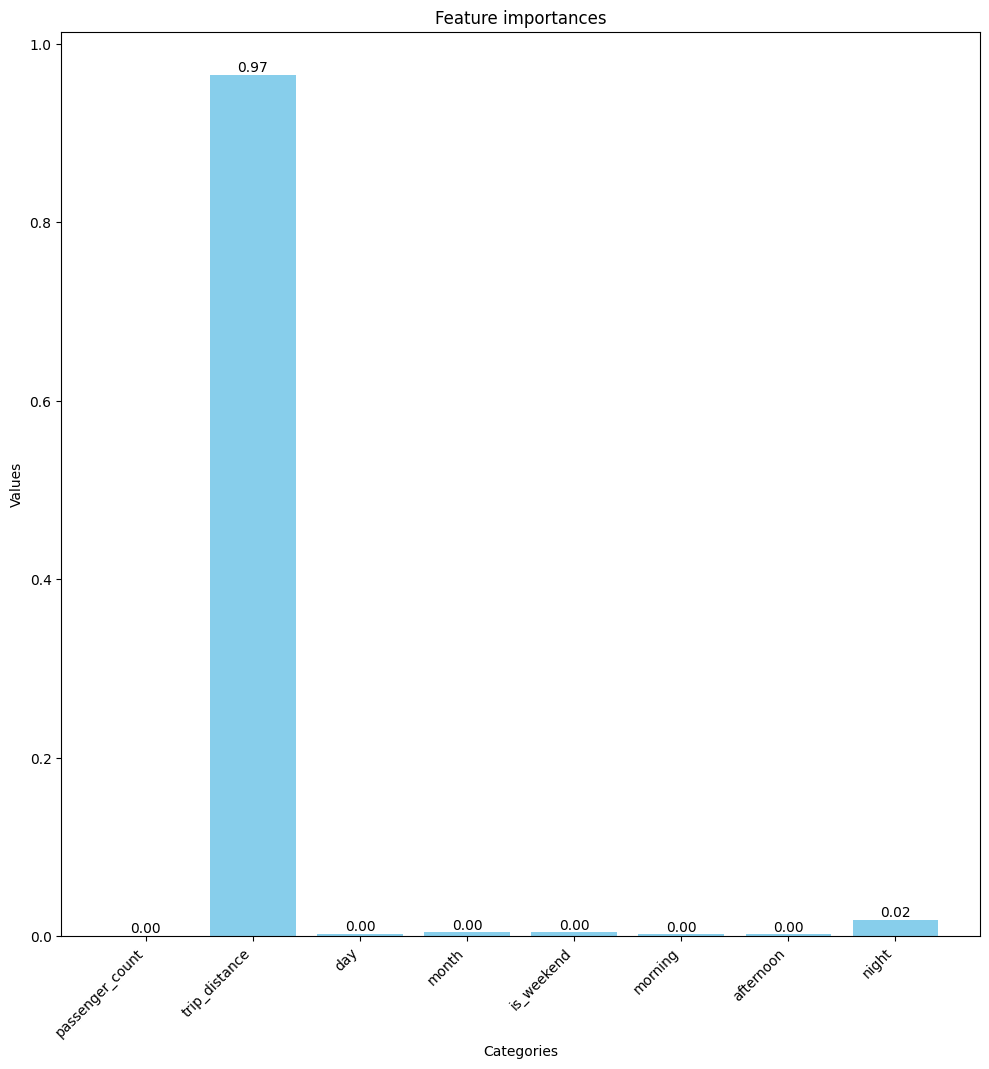

In [15]:
# Feature importances when predicting the fare amount
# bar chart
plt.figure(figsize=(10,10))
fare_bars = plt.bar(column_names_order,xg_fa.feature_importances_,color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Feature importances")
# so everything fits and is readable
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
# to add values on top of each bar
for bar in fare_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, # x position (center of bar)
                yval,                             # y position (top of bar)
                f'{yval:.2f}',                    # Text label (format value)
                va='bottom',                      # Vertical alignment (above bar)
                ha='center') 


plt.show()

In [17]:
# initial run with no finetuning for travel time
# tt = travel time
xg_tt = XGBRegressor(seed=42)
xg_tt.fit(X_train,y_train_travel_time)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
preds_tt = xg_tt.predict(X_val)

In [19]:
# measure our results
r2_travel = r2_score(y_val_travel_time, preds_tt)
mae = mean_absolute_error(y_val_travel_time, preds_tt)
rmse = root_mean_squared_error(y_val_travel_time, preds_tt)
# agregar r2
print(f'R2 score: {r2_travel}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

R2 score: 0.7713319078979874
Mean Absolute Error: 209.613435035642
Root Mean Squared Error: 305.9578921627395


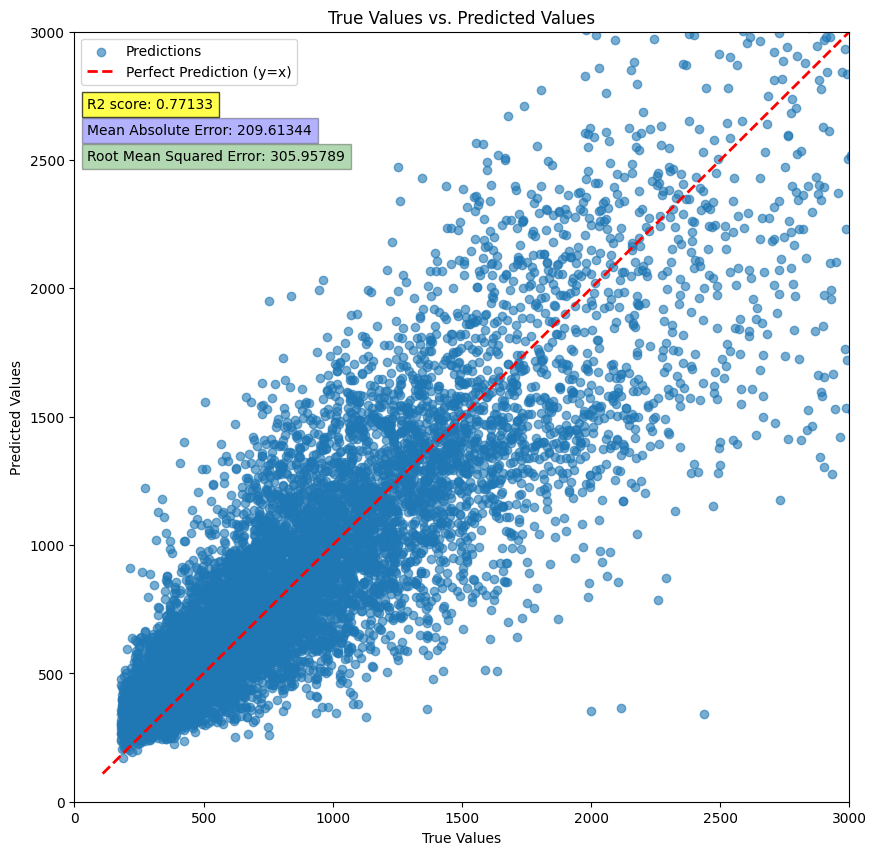

In [20]:
# plot the differences
plt.figure(figsize=(10,10))
plt.scatter(y_val_travel_time[:10000], preds_tt[:10000], alpha=0.6, label='Predictions')
# axis limits
plt.xlim([0,3000])
plt.ylim([0,3000])
#plotting perfect line
min_val = min(np.min(y_val_travel_time), np.min(preds_tt))
max_val = max(np.max(y_val_travel_time), np.max(preds_tt))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
# other settings
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True Values vs. Predicted Values")
#plt.grid(True)
plt.legend()
plt.text(50,2700,f'R2 score: {r2_travel:.5f}',bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(50,2600,f'Mean Absolute Error: {mae:.5f}',bbox=dict(facecolor='blue', alpha=0.3))
plt.text(50,2500,f'Root Mean Squared Error: {rmse:.5f}',bbox=dict(facecolor='green', alpha=0.3))
plt.show()

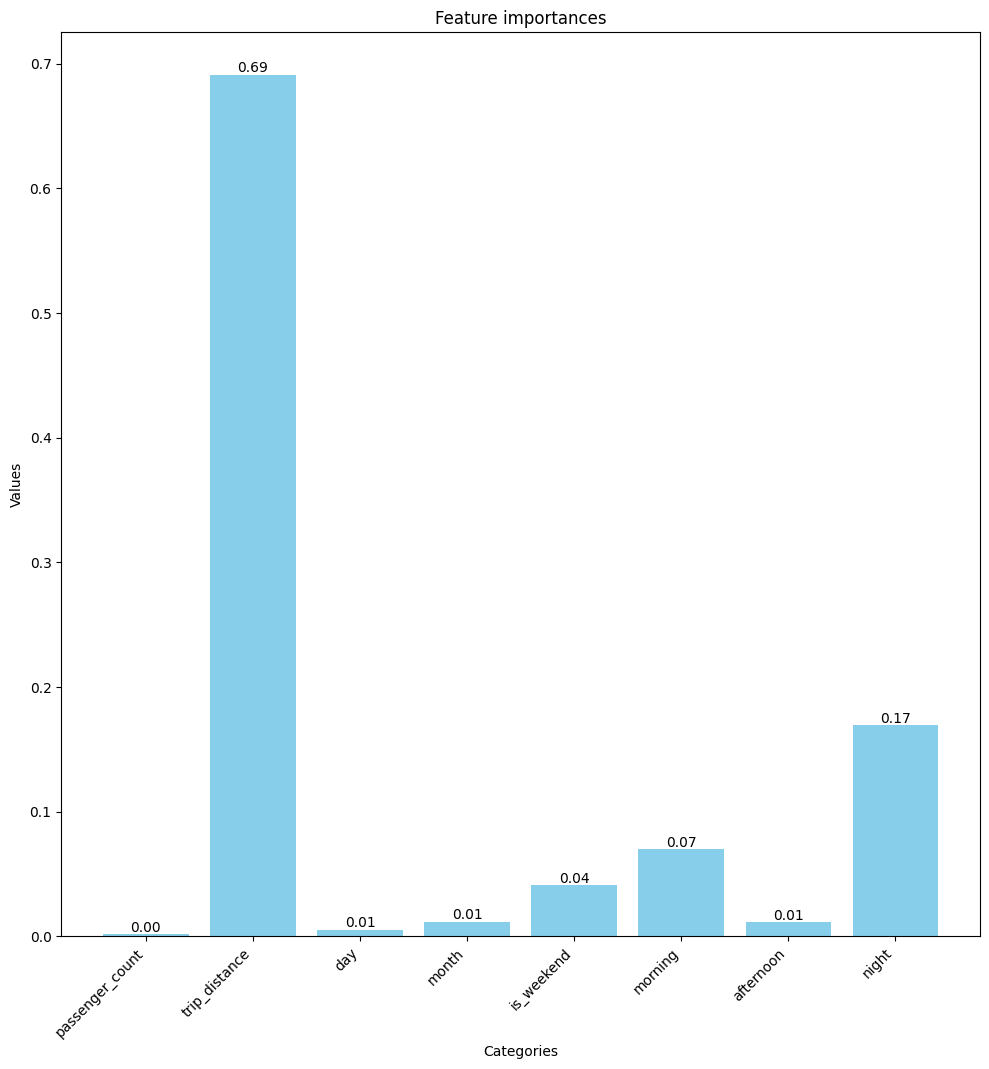

In [21]:
# bar charts for feature importances when predicting the travel time
# bar chart
plt.figure(figsize=(10,10))
fare_bars = plt.bar(column_names_order,xg_tt.feature_importances_,color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Feature importances")
# so everything fits and is readable
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
# to add values on top of each bar
for bar in fare_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, # x position (center of bar)
                yval,                             # y position (top of bar)
                f'{yval:.2f}',                    # Text label (format value)
                va='bottom',                      # Vertical alignment (above bar)
                ha='center') 


plt.show()

**Hyperparameter tuning**

In [42]:
from sklearn.model_selection import RandomizedSearchCV

**Travel time**

We will only focus on doing hyperparameter tuning for the travel time predictions, since the R2 score for the baseline model was significantly lower than the one for the fare amount

In [ ]:
# we'll start with optimizing the model to predict fare amount
xg_tt_opt = XGBRegressor(n_jobs=-1,random_state=42,tree_method='hist')

# we will choose from the following parameters to perform our cross validation search
xg_params_tt = {'n_estimators':[int(x) for x in np.linspace(start=100,stop=500,num=5)], # 100,200,300...1000
             'max_depth':[int(x) for x in np.linspace(start=10,stop=50,num=5)],
             }

# xg_params_tt = {'n_estimators':[int(x) for x in np.linspace(start=500,stop=1000,num=5)], # 100,200,300...1000
#              #'learning_rate':[x for x in np.linspace(start=0.01,stop=0.3,num=5)],
#              'max_depth':[int(x) for x in np.linspace(start=10,stop=50,num=5)],
#             #  'subsample':[0.25,0.5,0.75,1.0],
#             #  'colsample_bytree':[0.25,0.5,0.75,1.0],
#             #  'gamma':[0.25,0.5,0.75,1.0],
#             #  'alpha':[0,0.1,0.25,0.5,1.0,1.5,2.0],
#             #  'lambda':[1.0,1.5,2.0,2.5,3.0,3.5,4.0],
#             #  'min_child_weight':[1.0,1.5,2.0,2.5,3.0,3.5,4.0],
#              'objective':['reg:squarederror'],
#              'eval_metric':['rmse']
#              }

n_iterations_fa = 20

clf_travel_time = RandomizedSearchCV(estimator=xg_tt_opt,
                                     param_distributions=xg_params_tt,
                                     n_iter=n_iterations_fa,
                                     cv=5,
                                     scoring='neg_root_mean_squared_error',
                                     verbose=3,
                                     n_jobs=-1,
                                     random_state=42)

In [49]:
clf_travel_time.fit(X_train,y_train_fare_amount)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 